### Imports

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.initializers import GlorotNormal

In [12]:
# Plot function

def plot_feature(dataset:pd.DataFrame, featureName:str):
    
    fig, axs = plt.subplots(1, 1, figsize=(20, 10))

    dataset[['date_forecast', featureName]].set_index("date_forecast").plot(ax=axs, title=featureName, color='red')

# Data preperation

In [13]:
# Get data, combine and sort

data_test_A = pd.read_csv("current_csv_files/data_test_A.csv", index_col='Unnamed: 0')
data_test_B = pd.read_csv("current_csv_files/data_test_B.csv", index_col='Unnamed: 0')
data_test_C = pd.read_csv("current_csv_files/data_test_C.csv", index_col='Unnamed: 0')

data_test_ALL = pd.concat([data_test_A, data_test_B, data_test_C], ignore_index=True)
data_test_ALL = data_test_ALL.sort_values(['date_forecast', 'A', 'B', 'C'], ascending=[True, False, False, False])
data_test_ALL = data_test_ALL.set_index('date_forecast')
data_test_ALL.rename(columns={'pv_measurement': 'target'}, inplace=True)

In [14]:
# Split data

data_ALL = data_test_ALL[data_test_ALL['train'] == 1]
test_ALL = data_test_ALL[data_test_ALL['train'] == 0].drop('target', axis='columns')

In [15]:
# Separate features and target variable
X = data_ALL.drop('target', axis='columns')
y = data_ALL['target']

In [16]:
# Split data

def split_data(df, percent):
    split_index = int( np.floor( len(df)*percent ) )
    df_first = df[:split_index]
    df_last = df[split_index:]
    return df_first, df_last

train_percent = 0.94 # Of all
val_percent = 0.5 # Of non-train

X_train, X_non_train = split_data(X, train_percent)
X_val, X_test = split_data(X_non_train, val_percent)

y_train, y_non_train = split_data(y, train_percent)
y_val, y_test = split_data(y_non_train, val_percent)

X_kaggle = test_ALL


In [17]:
# Prepare features for scaling

feature_dont_touch = [
    'date_forecast',
    'is_day:idx',
    'is_in_shadow:idx',
    'pv_measurement',
    'est',
    'train',
    'A',
    'B',
    'C',
    'precip_type_0',
    'precip_type_1',
    'daily_sinus',
    'annual_sinus',
    'bad_cloud_data'
]

feature_to_standardize = [
    'absolute_humidity_2m:gm3',
    'air_density_2m:kgm3',
    'dew_point_2m:K',
    'pressure_100m:hPa',
    'relative_humidity_1000hPa:p',
    't_1000hPa:K',
    'wind_speed_u_10m:ms',
    'wind_speed_v_10m:ms'
]

feature_to_normalize = [
    'cloud_base_agl:m_y',
    'clear_sky_energy_1h:J',
    'diffuse_rad_1h:J',
    'direct_rad_1h:J',
    'precip_5min:mm',
    'rain_water:kgm2',
    'snow_water:kgm2',
    'super_cooled_liquid_water:kgm2',
    'clear_sky_rad:W',
    'diffuse_rad:W',
    'direct_rad:W',
    'effective_cloud_cover:p',
    'sun_azimuth:d',
    'total_cloud_cover:p',
    'visibility:m',
    'wind_speed_10m:ms',
    'sun_elevation:d', # Clipped version
    'year',
    'month',
    'day',
]


In [18]:
# Scale features

standard_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()

for feature in feature_to_standardize:
    X_train[feature] = standard_scaler.fit_transform(X_train[[feature]])
    
    X_non_train[feature] = standard_scaler.transform(X_non_train[[feature]])
    X_val[feature] = standard_scaler.transform(X_val[[feature]])
    X_test[feature] = standard_scaler.transform(X_test[[feature]])
    X_kaggle[feature] = standard_scaler.transform(X_kaggle[[feature]])
    

for feature in feature_to_normalize:
    X_train[feature] = min_max_scaler.fit_transform(X_train[[feature]])
    
    X_non_train[feature] = min_max_scaler.transform(X_non_train[[feature]])
    X_val[feature] = min_max_scaler.transform(X_val[[feature]])
    X_test[feature] = min_max_scaler.transform(X_test[[feature]])
    X_kaggle[feature] = min_max_scaler.transform(X_kaggle[[feature]])

/var/folders/kq/hk1l39ys077bc7f9741ypg800000gn/T/ipykernel_10123/1841776178.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[feature] = standard_scaler.fit_transform(X_train[[feature]])
/var/folders/kq/hk1l39ys077bc7f9741ypg800000gn/T/ipykernel_10123/1841776178.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_non_train[feature] = standard_scaler.transform(X_non_train[[feature]])
/var/folders/kq/hk1l39ys077bc7f9741ypg800000gn/T/ipykernel_10123/1841776178.py:10: SettingWithCopyWarning: 
A valu

# Model training

In [19]:
class CustomModelCheckpoint(Callback):
    def __init__(self, best_weights, i):
        self.best_weights = best_weights  # Dictionary to store best weights
        self.best_loss = np.inf
        self.model_index = i  # Index to handle the specific model in the list

    def on_epoch_end(self, epoch, logs=None):
        # Monitor the validation loss
        current_val_loss = logs.get('val_loss')
        if current_val_loss < self.best_loss:
            # Update the best loss and best weights
            self.best_loss = current_val_loss
            self.best_weights[self.model_index] = self.model.get_weights()

In [20]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

N = 1
nets = []
init = 'HeNormal'

# Initialize dictionary to store the best weights for each model
best_weights_during_training = {}

for i in range(N):
    # Define the Keras model
    model = Sequential([
        Dense(256, input_dim=X_train.shape[1], activation='tanh', kernel_initializer=init),
        #Dropout(0.2, (150,), seed=seeds[5]),
        Dense(256, activation='relu', kernel_initializer=init),
        #Dense(120, activation='relu', kernel_initializer=inits[2], kernel_regularizer=l2(0.05)),
        Dense(128, activation='relu', kernel_initializer=init),
        Dense(64, activation='relu', kernel_initializer=init),
        Dense(1, activation='relu', kernel_initializer=init)
    ])
    nets.append(model)

    opt = Adam(learning_rate=0.001)
    model.compile(loss='mean_absolute_error', optimizer=opt)

    # Define early stopping
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=1, patience=10)

    # Create an instance of the custom checkpoint for the current model
    custom_checkpoint = CustomModelCheckpoint(best_weights_during_training, i)

    # Fit the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_non_train, y_non_train),
        #validation_split=0.2,
        epochs=100,
        batch_size=32,
        callbacks=[early_stopping, custom_checkpoint]
    )

    # Store the best weights for the current model
    if i not in best_weights_during_training:
        # If the model didn't improve, just save the last weights
        best_weights_during_training[i] = model.get_weights()

    prediction = model.predict(X_non_train)
    print(i, " MAE: ", mean_absolute_error(prediction, y_non_train))
    # Plot pred
    
    plt.figure(figsize=(20, 7))
    plt.plot(prediction, alpha=0.5)
    plt.ylabel('Predicted Target Values')
    plt.show()
    

    

Epoch 1/100
2731/2731 [==============================] - 3s 1ms/step - loss: 112.8781 - val_loss: 101.3277
Epoch 2/100
 368/2731 [===>..........................] - ETA: 2s - loss: 94.2767

KeyboardInterrupt: 

# Making prediction

In [126]:
# Make predictions using the best test validation epoch
best_preds = []

for i in range(N):
    nets[i].set_weights(best_weights_during_training[i])
    best_preds.append(nets[i].predict(X_non_train).ravel()) # Select dataset of choice
    print(i, "MAE: ", mean_absolute_error(y_non_train, best_preds[i]))

175/175 [==============================] - 0s 515us/step
0 MAE:  88.9113066837359
175/175 [==============================] - 0s 462us/step
1 MAE:  89.4273040651171
175/175 [==============================] - 0s 475us/step
2 MAE:  91.6874854988511
175/175 [==============================] - 0s 513us/step
3 MAE:  90.31275494481588
175/175 [==============================] - 0s 490us/step
4 MAE:  91.51212414305533
175/175 [==============================] - 0s 767us/step
5 MAE:  91.14033348612026
175/175 [==============================] - 0s 460us/step
6 MAE:  90.87893552901771
175/175 [==============================] - 0s 552us/step
7 MAE:  88.13167835116013
175/175 [==============================] - 0s 465us/step
8 MAE:  91.06386822525626
175/175 [==============================] - 0s 478us/step
9 MAE:  90.03203744051045


In [127]:
# Create dataframe
df_best_preds = pd.DataFrame(best_preds).T

df_best_preds['avg'] = df_best_preds.mean(axis='columns')

In [138]:
df_best_preds

,0,1,2,3,4,5,6,7,8,9,avg
0,0.000000,26.770554,18.336561,17.226801,15.353435,20.446899,10.105970,14.716593,5.706990,2.085349,13.074915
1,335.915924,513.566101,275.583221,268.393646,242.171509,378.666229,382.066925,330.249756,316.322876,427.687836,347.062378
2,0.000000,24.011923,5.988428,2.156328,0.896857,4.850194,3.471783,2.623480,1.970294,0.000000,4.596929
3,0.000000,74.680679,11.198603,0.000000,0.000000,15.886543,11.724668,11.861152,10.078298,5.754906,14.118484
4,0.000000,1.166825,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.116682
...,...,...,...,...,...,...,...,...,...,...,...
5573,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5574,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5575,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5576,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


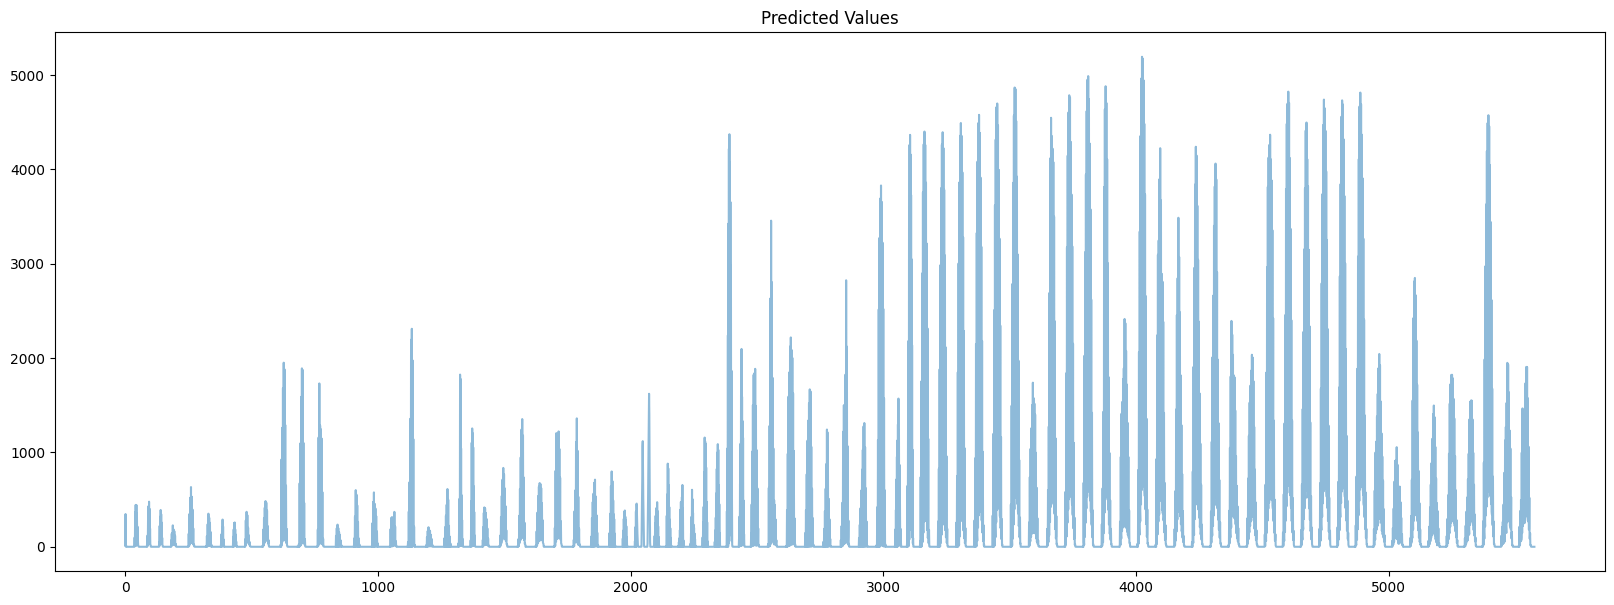

In [128]:
plt.figure(figsize=(20, 7))
plt.plot(df_best_preds['avg'], alpha=0.5)
plt.title('Predicted Values')
plt.show()

In [129]:
print("MAE: ", mean_absolute_error(y_non_train, df_best_preds['avg']))

MAE:  87.79013393395199


In [61]:
from sklearn.linear_model import LinearRegression

LR_model = LinearRegression()
LR_model.fit(df_best_preds.iloc[: , :N], y_test) # Select dataset of choice

LinearRegression()

In [130]:
# Make kaggle prediction
best_kaggle_preds = []

for i in range(N):
    best_kaggle_preds.append(nets[i].predict(X_kaggle).ravel())

68/68 [==============================] - 0s 524us/step


In [131]:
# Create dataframe for kaggle pred
df_kaggle_preds = pd.DataFrame(best_kaggle_preds).T

df_kaggle_preds['avg'] = df_kaggle_preds.mean(axis='columns')

In [75]:
kaggle_pred = LR_model.predict(df_kaggle_preds.iloc[: , :N])
kaggle_pred = kaggle_pred.clip(min=0)

In [141]:
df_kaggle_preds

,0,1,2,3,4,5,6,7,8,9,avg
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2156,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2158,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [175]:
# Merge with kaggle_test data
test_ALL_to_sub = pd.read_csv("current_csv_files/test_ALL.csv")
test_ALL_to_sub['prediction'] = df_kaggle_preds.iloc[:, 7]

In [176]:
# Correctly sort test data for submission
test_ALL_sorted = test_ALL_to_sub.sort_values(['A', 'B', 'C', 'date_forecast'], ascending=[False, False, False, True])
test_ALL_sorted['id'] = range(2160)

MAE:  111.88395444869694


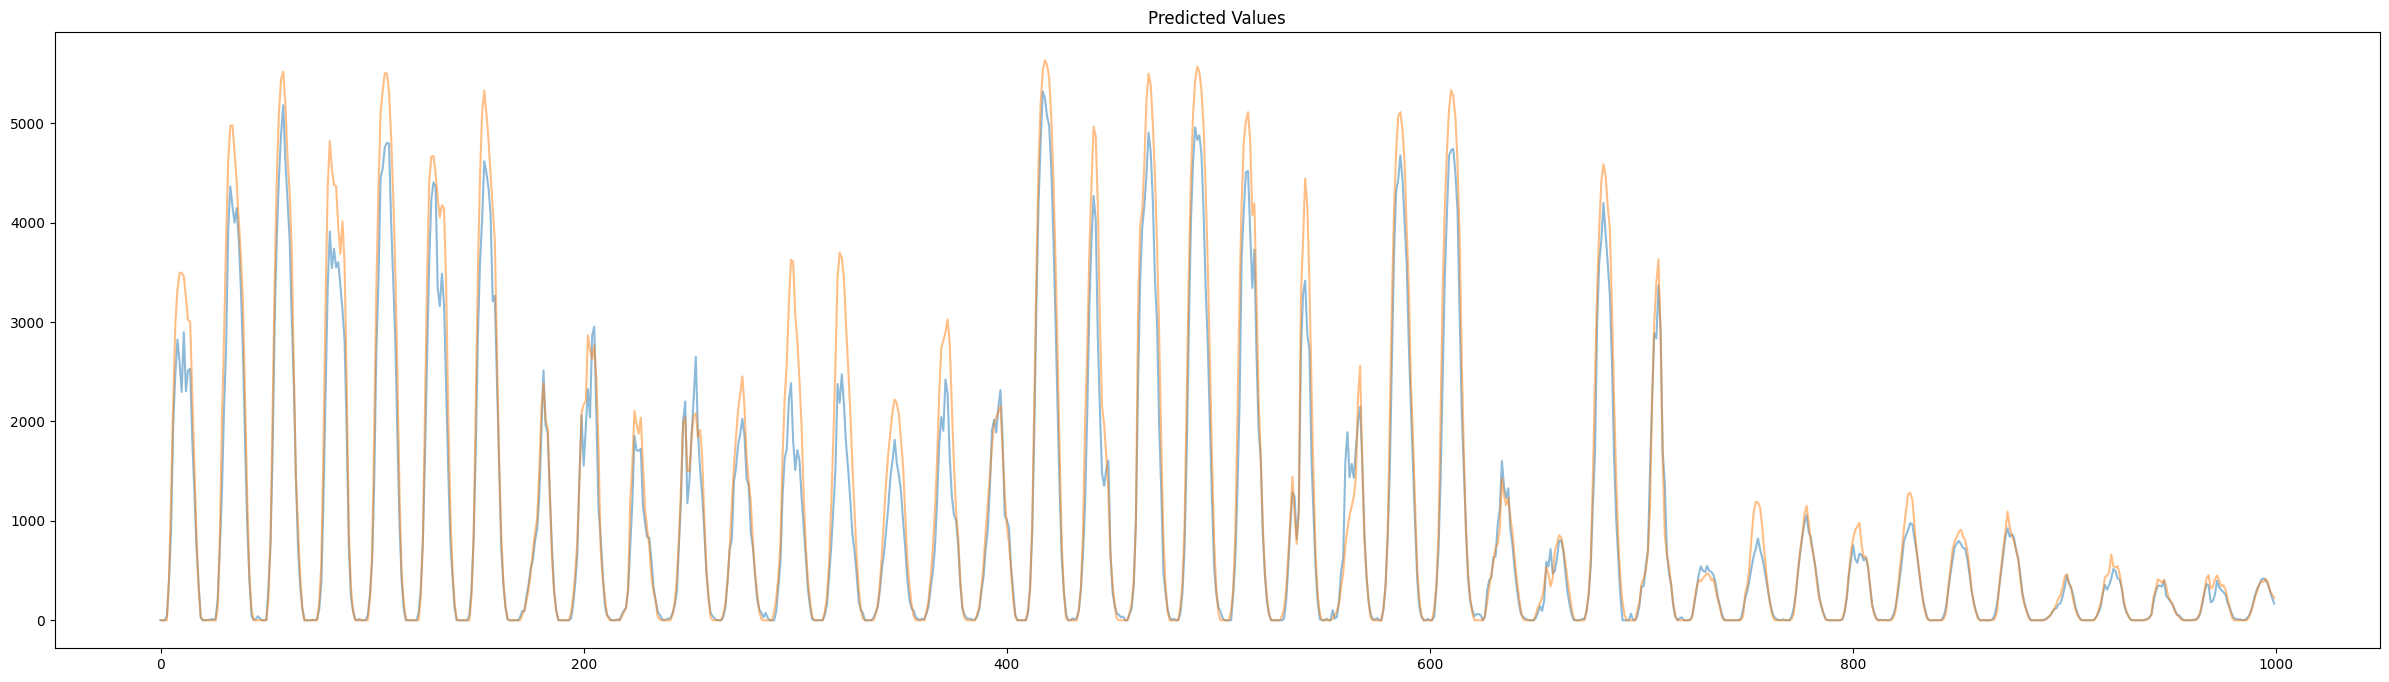

In [177]:
# Comparison to best sub on kaggle

best_sub = pd.read_csv("teo_subs/best_sub.csv", index_col='id')
print("MAE: ", mean_absolute_error(test_ALL_sorted['prediction'], best_sub))

slide = 0
start = 0 + slide
stop = 1000 + slide

plt.figure(figsize=(30, 8))
plt.plot(range(start, stop), best_sub.iloc[start:stop], alpha=0.5)
plt.plot(range(start, stop), test_ALL_sorted['prediction'].iloc[start:stop], alpha=0.5)
plt.title('Predicted Values')
plt.show()

In [161]:
test_ALL_sorted[['id', 'prediction']].to_csv("teo_subs/teo_sub_10.csv", index=False)

In [162]:
cat_sub = pd.read_csv("teo_subs/best_sub.csv", index_col='id')

avg_pred = (cat_sub + test_ALL_sorted['prediction'])/2
avg_pred.to_csv("teo_subs/teo_sub_8.csv")